<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex3/3_notebook1_GPU/3_1_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1 - Feedback tone

In [ ]:
!pip install -q keras

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
import keras
from tqdm.notebook import tqdm
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()
warnings.filterwarnings("ignore")

In [ ]:
# Check and configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
folder_path = ('/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex3/3_notebook1_GPU')
os.chdir(folder_path)

In [ ]:
# Load dataset
df = pd.read_csv('data/hotels.csv')

## Data inspection

In [ ]:
df.drop_duplicates(inplace= True)

In [ ]:
df.dropna(subset=['Review'], inplace=True)

In [ ]:
df.isna().sum()

,0
S.No.,0
Review,0
Rating,0


In [ ]:
# Mapping ratings to sentiments
rating_to_sentiment = {
    1: 'Extremely Negative',
    2: 'Negative',
    3: 'Neutral',
    4: 'Positive',
    5: 'Extremely Positive'
}

In [ ]:
df['Sentiment'] = df['Rating'].map(rating_to_sentiment)

In [ ]:
df.head()

,S.No.,Review,Rating,Sentiment
0,1,nice hotel expensive parking got good deal sta...,4,Positive
1,2,ok nothing special charge diamond member hilto...,2,Negative
2,3,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,4,unique \tgreat stay \twonderful time hotel mon...,5,Extremely Positive
4,5,great stay great stay \twent seahawk game awes...,5,Extremely Positive


In [ ]:
print(f"There are {df.shape[0]} entries in the dataframe")

There are 20491 entries in the dataframe


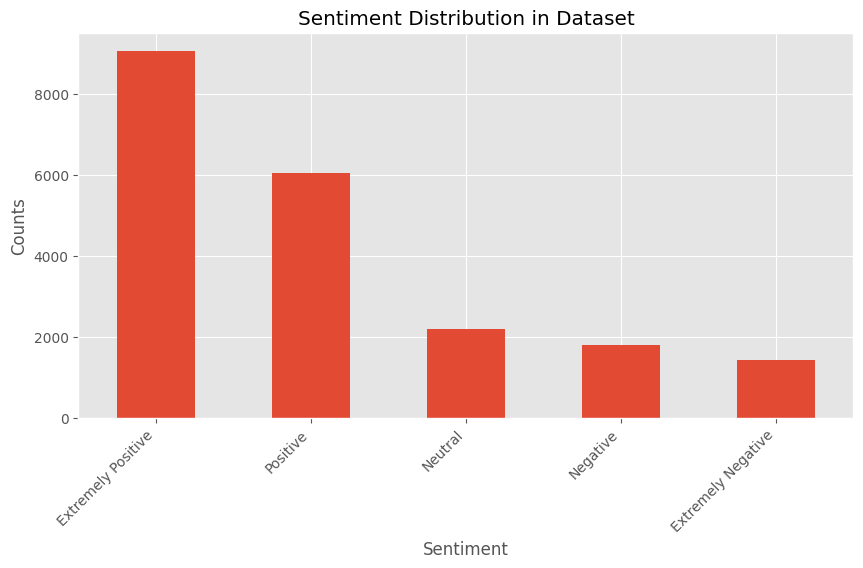

In [ ]:
# distribution of sentiments
reorder = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

plt.figure(figsize=(10, 5))
df['Sentiment'].value_counts().reindex(index=reorder).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Sentiment Distribution in Dataset')
plt.ylabel('Counts')
plt.show()

In [ ]:
max_words = [len(review.split()) for review in df['Review']]
print(f"The max word count in reviews is {np.max(max_words)}")

The max word count in reviews is 1931


In [ ]:
avg_words = (df['Review'].apply(lambda x: len(x.split()))).mean()
print(f"The average number of words: {avg_words:.2f}")

The average number of words: 104.38


## Preparation

In [ ]:
# Combining Labels
def combining_labels(row):
    if row == 'Extremely Positive':
        return 'Positive'
    if row == 'Extremely Negative':
        return 'Negative'
    return row

In [ ]:
df['Simple_Sentiment'] = df['Sentiment'].apply(combining_labels)

In [ ]:
df.head()

,S.No.,Review,Rating,Sentiment,Simple_Sentiment
0,1,nice hotel expensive parking got good deal sta...,4,Positive,Positive
1,2,ok nothing special charge diamond member hilto...,2,Negative,Negative
2,3,nice rooms not 4* experience hotel monaco seat...,3,Neutral,Neutral
3,4,unique \tgreat stay \twonderful time hotel mon...,5,Extremely Positive,Positive
4,5,great stay great stay \twent seahawk game awes...,5,Extremely Positive,Positive


In [ ]:
def remove_tabs(row):
  return row['Review'].replace("\t", "")

In [ ]:
df['Review'] = df.apply(remove_tabs, axis=1)

In [ ]:
# encode labels to numeric
le = LabelEncoder()
df['Simple_Sentiment_label'] = le.fit_transform(df['Simple_Sentiment'])

In [ ]:
df = df.drop(columns=['S.No.','Sentiment','Rating'])

In [ ]:
df.head()

,Review,Simple_Sentiment,Simple_Sentiment_label
0,nice hotel expensive parking got good deal sta...,Positive,2
1,ok nothing special charge diamond member hilto...,Negative,0
2,nice rooms not 4* experience hotel monaco seat...,Neutral,1
3,unique great stay wonderful time hotel monaco ...,Positive,2
4,great stay great stay went seahawk game awesom...,Positive,2


In [ ]:
#  dictionary mapping sentiment labels to their corresponding simple sentiment values
label_dict = df[['Simple_Sentiment', 'Simple_Sentiment_label']].drop_duplicates().sort_values(by='Simple_Sentiment_label').set_index('Simple_Sentiment_label').to_dict()['Simple_Sentiment']

In [ ]:
for index, key in label_dict.items():
    print(index, key)

0 Negative
1 Neutral
2 Positive


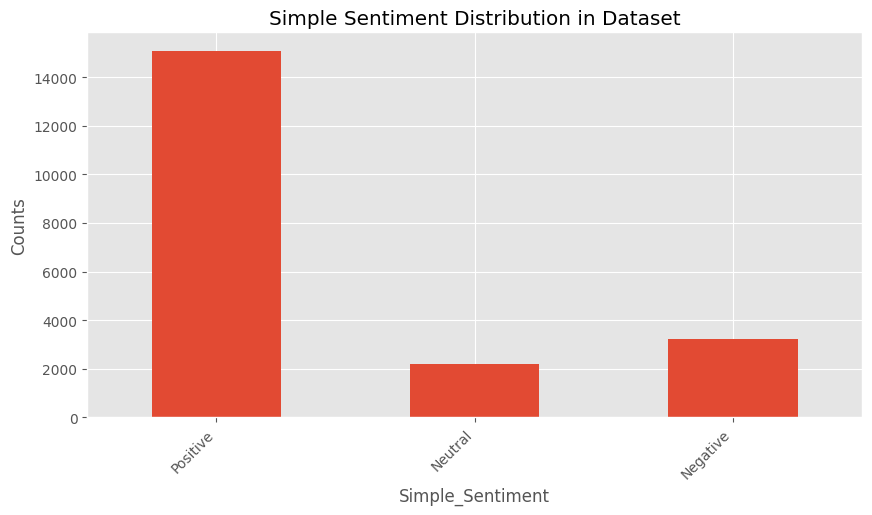

In [ ]:
# Plotting the distribution of sentiments
reorder = ['Positive', 'Neutral', 'Negative']

plt.figure(figsize=(10, 5))
df['Simple_Sentiment'].value_counts().reindex(index=reorder).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Simple Sentiment Distribution in Dataset')
plt.ylabel('Counts')
plt.show()

## Build the model and Train

In [ ]:
# Splitting the data 80/20, then 80/10/10
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
MAX_LENGTH = 235
MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,
                                                max_length=MAX_LENGTH,
                                                pad_to_max_length=True)

tokenizer.add_special_tokens({'additional_special_tokens': ['[your_special_token]']})

def tokenize(sentences, tokenizer):
    input_ids, attention_masks = [], []
    for sentence in tqdm(sentences, desc='Tokenizing'):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       padding='max_length',
                                       truncation=True,
                                       return_attention_mask=True)
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids, dtype='int32'), np.array(attention_masks, dtype='int32')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
x_train, x_train_masks = tokenize(train_df['Review'], tokenizer)
x_val, x_val_masks = tokenize(val_df['Review'], tokenizer)
x_test, x_test_masks = tokenize(test_df['Review'], tokenizer)

Tokenizing:   0%|          | 0/16392 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/2049 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/2050 [00:00<?, ?it/s]

In [ ]:
y_train = train_df['Simple_Sentiment_label'].values
y_val = val_df['Simple_Sentiment_label'].values
y_test = test_df['Simple_Sentiment_label'].values

In [ ]:
print(f"X_train shape: {x_train.shape}")
print(f"Y_train shape: {y_train.shape}")

X_train shape: (16392, 235)
Y_train shape: (16392,)


In [ ]:
print(f"{len(y_train)} training examples\n{len(y_val)} validation examples")
print(f"{len(y_test)} testing examples")

16392 training examples
2049 validation examples
2050 testing examples


In [ ]:
df.head()

,Review,Simple_Sentiment,Simple_Sentiment_label
0,nice hotel expensive parking got good deal sta...,Positive,2
1,ok nothing special charge diamond member hilto...,Negative,0
2,nice rooms not 4* experience hotel monaco seat...,Neutral,1
3,unique great stay wonderful time hotel monaco ...,Positive,2
4,great stay great stay went seahawk game awesom...,Positive,2


In [ ]:
# DistilBERT configuration with hidden states, attentions, and return as a dictionary
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

# Input layers for token IDs and attention masks
input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
attention_mask_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

# model architecture
embedding_layer = DistilBERT(input_ids=input_ids_in, attention_mask=attention_mask_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, attention_mask_in], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 235)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 235)]                0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6519091   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 235, 768)   2          'masked_token[0][0]']        
                             , hidden_states=((None, 23                                           
                             5, 768),                                                         

In [ ]:
# Keras Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0, mode='min', restore_best_weights=False, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              min_lr=0.000001,
                              patience=1,
                              mode='min',
                              factor=0.1,
                              min_delta=0.01,
                              verbose=1)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# TRAIN
history = model.fit(
    [x_train, x_train_masks],
    y_train,
    epochs=10,
    batch_size=16,
    validation_data=([x_val, x_val_masks], y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
1025/1025 [==============================] - 206s 189ms/step - loss: 0.4664 - accuracy: 0.8277 - val_loss: 0.3623 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 2/10
1025/1025 [==============================] - 193s 188ms/step - loss: 0.3776 - accuracy: 0.8540 - val_loss: 0.3136 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 3/10
1025/1025 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.8632
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1025/1025 [==============================] - 193s 188ms/step - loss: 0.3496 - accuracy: 0.8632 - val_loss: 0.3198 - val_accuracy: 0.8790 - lr: 0.0010
Epoch 4/10
1025/1025 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8812
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1025/1025 [==============================] - 190s 186ms/step - loss: 0.2993 - accuracy: 0.8812 - val_loss: 0.3127 - val_accuracy: 0.8853 - lr: 1.0000e-04
Epoch 5/10
1025/1025 [==

In [ ]:
model.save('models/sentiment_model.h5')

## Model evaluation

In [ ]:
# Function to plot the training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

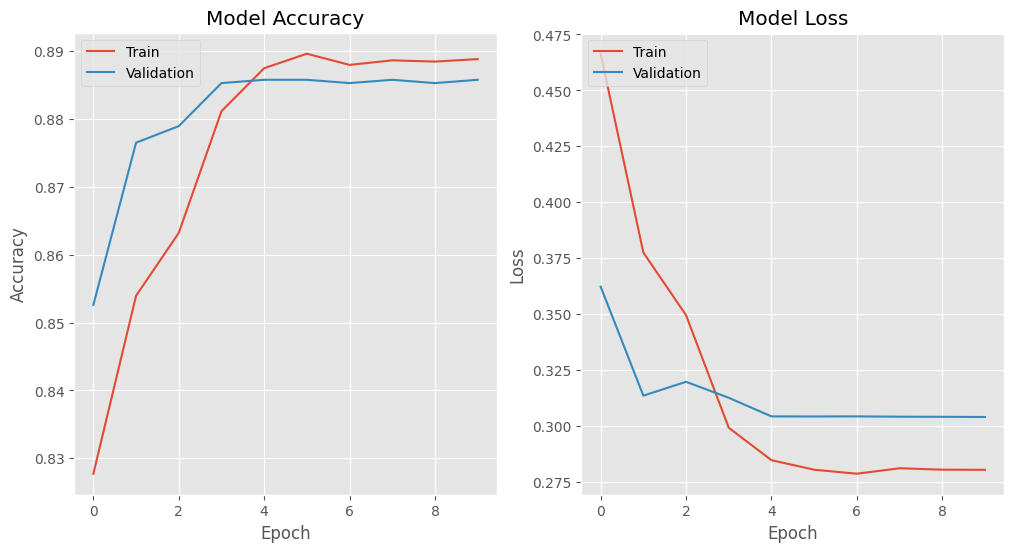

In [ ]:
# Plot training and validation history
plot_history(history)

In [ ]:
# Predict on the test set
y_test_probs = model.predict([x_test, x_test_masks])

65/65 [==============================] - 19s 266ms/step


In [ ]:
# Convert probabilities to integer predictions
y_hat = np.argmax(y_test_probs, axis=1)

In [ ]:
def print_cf2(y_true, y_pred, label_dict):
    cm = confusion_matrix(y_true, y_pred)

    labels = [label_dict[key] for key in sorted(label_dict.keys())]
    # seaborn heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.8668292682926829


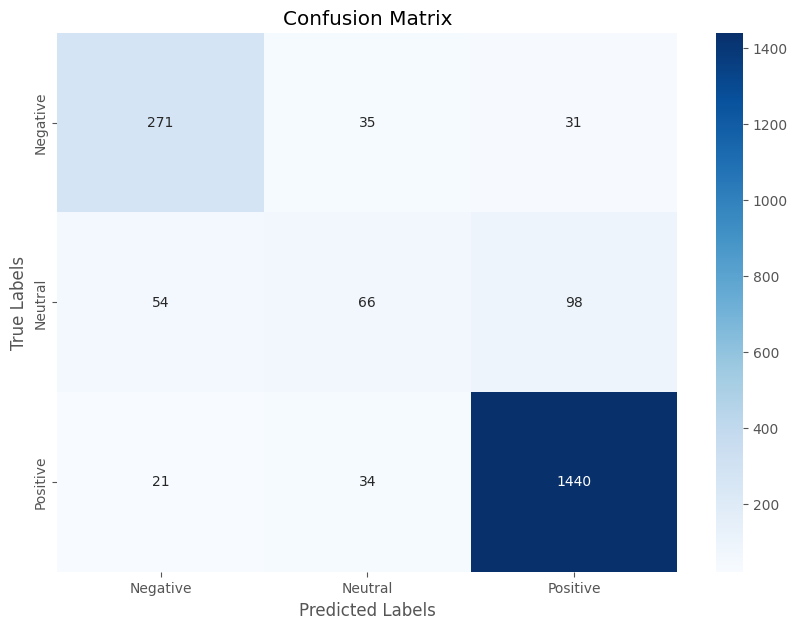

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf2(y_test, y_hat,label_dict)

In [ ]:
# classification report
labels_3 = ['Positive', 'Neutral', 'Negative']
print(classification_report(y_test, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Positive       0.78      0.80      0.79       337
     Neutral       0.49      0.30      0.37       218
    Negative       0.92      0.96      0.94      1495

    accuracy                           0.87      2050
   macro avg       0.73      0.69      0.70      2050
weighted avg       0.85      0.87      0.86      2050



In [ ]:
examples = test_df['Review'].values
misclassified_examples = examples[(y_test == 1) & (y_hat == 0)][:5]

print("\nExamples of 'Neutral' misclassified as 'Positive':\n")
for i, example in enumerate(misclassified_examples, 1):
    print(f"Example {i}:\n{example}\n{'-'*80}\n")


Examples of 'Neutral' misclassified as 'Positive':

Example 1:
great location services dirty old hi hotel greatest location near shopping ships mtr room old bathroom scary roof falling old towels papers pillows stink walls room dirt realy dirty carpet stain cloth pillow able sleep size great people eager help speak english cheking fast stay renovate rooms location really great  
--------------------------------------------------------------------------------

Example 2:
bathroom shower hotel staff good.you sit bathtub order use hand shower no refrigerator room  
--------------------------------------------------------------------------------

Example 3:
mixed views stayed 3 nights singapore stopover package.best thing hotel convenient location just stopover traveller needs.i got hotel checked quite early 15hr flight understandable room n't ready said approx 6hrs told return room ready bags awaiting not stage desperate shower change clothes took 2 phone calls hour bags arrived room hin

In [ ]:
print("Examples of 'Positive' misclassified as 'Negative':")
[print(example, '\n') for example in examples[(y_test == 0) & (y_hat == 2)][:5]]

Examples of 'Positive' misclassified as 'Negative':
bogan central husband stayed aston 2 nights november 2008. come places highly reccomend sofitel seminyak stunning jati homestay sanur gorgeous cheap price paid aston just n't worth money not really bad just not good service help bags general questions needs asked offered somewhat reluctant attitude stayed suite nice view no aircon cockroaches boiling aircon fan ca n't really sleep balcony door open mossies come in.the pool area ok looks beach place appeal certain demographic middle aged bogans australians lots russians roll pool drinks hands getting drunker louder hours pass peaceful swim no doubt bring face face graceless couples shamelessly gropping lay sunbed sipping badly expensive cocktail sent sewerage wafted bar area breeze thought gone surfers paradise.on positive note shopping bali galleria great suveniers clothes cheaper hardies locals shop shuttle bus takes bali galleria free taxi hardies 30,000hope helped selamat tingal   

[None, None, None, None, None]

In [ ]:
# predictions to decimal format for easier reading
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

test_list = ["good hotel nice service excellent breakfast",
             "never again worst service rude and expensive",
             "price is good service is bad",
             "great service, absolutely fabulous, said no one ever. never again"]

# X_train = tokenize(x_train, tokenizer)
test_new = tokenize(test_list, tokenizer)
test_probs = model.predict(test_new)

counter = 0

for test_prob in test_probs:
    print(test_list[counter])
    print(test_prob)

    test_index = np.argmax(test_prob)
    print(labels_3[test_index])
    print("-------------------------------")
    counter += 1

Tokenizing:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
good hotel nice service excellent breakfast
[0.000282 0.015258 0.984460]
Negative
-------------------------------
never again worst service rude and expensive
[0.887782 0.050508 0.061710]
Positive
-------------------------------
price is good service is bad
[0.284598 0.448884 0.266518]
Neutral
-------------------------------
great service, absolutely fabulous, said no one ever. never again
[0.000027 0.000646 0.999326]
Negative
-------------------------------
